# Training a CNN to predict or assess sleep quality based on heart rate time series data

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

## Data preprocessing for TensorFlow

In [548]:
X = np.load('hr_arr.npy')
y = np.load('score_arr.npy')

In [549]:
x_scaler = MinMaxScaler()
X = x_scaler.fit_transform(X)

In [550]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [551]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Convolutional model

In [905]:
class cnnModel(nn.Module):
    def __init__(self):
        super(cnnModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm1d(4)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm1d(8)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm1d(16)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16*6, 1)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

In [612]:
def train(model, train_loader, loss_fn, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

In [735]:
def evaluate(model, test_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            total_loss += loss.item()
        print(f'Loss: {total_loss}')

In [972]:
model = cnnModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [984]:
train(model, train_loader, loss_fn, optimizer, epochs=10)

Epoch 1, Loss: 416.18702697753906
Epoch 2, Loss: 410.98882484436035
Epoch 3, Loss: 408.382869720459
Epoch 4, Loss: 405.9883460998535
Epoch 5, Loss: 384.2627429962158
Epoch 6, Loss: 364.6037940979004
Epoch 7, Loss: 415.73470306396484
Epoch 8, Loss: 382.9629249572754
Epoch 9, Loss: 448.05076599121094
Epoch 10, Loss: 445.35405349731445


In [985]:
evaluate(model, test_loader, loss_fn)

Loss: 86.5179443359375


## Visualizing the model's performance

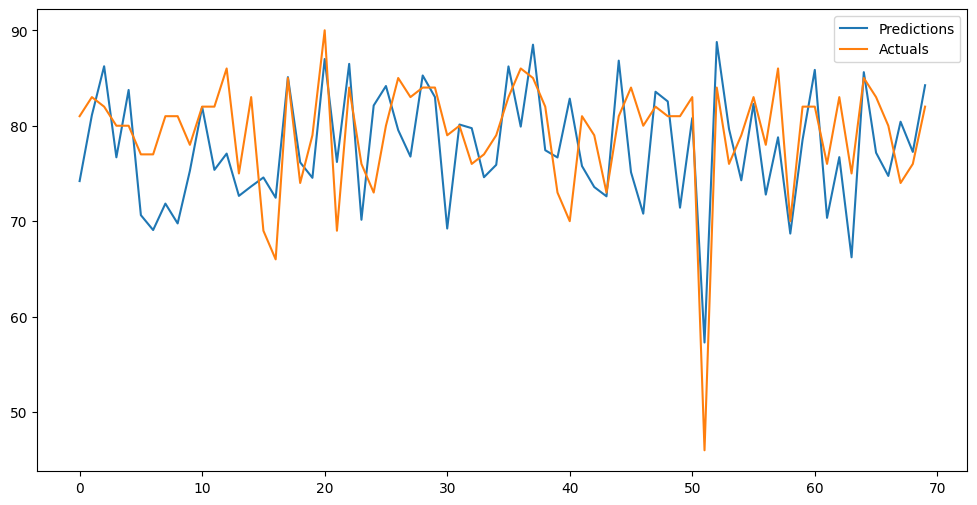

In [986]:
# predictions vs actual values on test set
model.eval()
all_preds = []
all_actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        all_preds.append(y_pred)
        all_actuals.append(y_batch)

all_preds_test = torch.cat(all_preds)
all_actuals_test = torch.cat(all_actuals)

plt.figure(figsize=(12, 6))
plt.plot(all_preds_test.numpy(), label='Predictions')
plt.plot(all_actuals_test.numpy(), label='Actuals')
plt.legend()
plt.show()

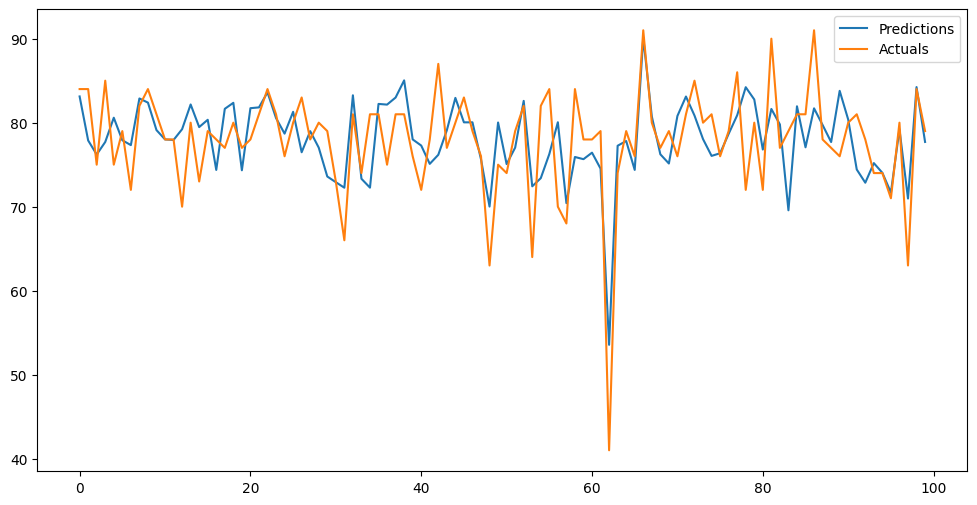

In [987]:
# predictions vs actual values on train set
model.eval()
all_preds = []
all_actuals = []

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        all_preds.append(y_pred)
        all_actuals.append(y_batch)

all_preds_train = torch.cat(all_preds)
all_actuals_train = torch.cat(all_actuals)

plt.figure(figsize=(12, 6))
plt.plot(all_preds_train[:100].numpy(), label='Predictions')
plt.plot(all_actuals_train[:100].numpy(), label='Actuals')
plt.legend()
plt.show()

In [988]:
residuals = all_actuals_test.flatten() - all_preds_test.flatten()
residuals = torch.abs(residuals)
largest_res = torch.topk(residuals, 3).indices

print('3 largest residuals:')
for i in largest_res:
    print(f'Actual: {all_actuals_test[i].item()}, Prediction: {all_preds_test[i].item()}')

smallest_res = torch.topk(-residuals, 3).indices

print('3 smallest residuals:')
for i in smallest_res:
    print(f'Actual: {all_actuals_test[i].item()}, Prediction: {all_preds_test[i].item()}')

3 largest residuals:
Actual: 70.0, Prediction: 82.84001159667969
Actual: 46.0, Prediction: 57.29051208496094
Actual: 81.0, Prediction: 69.76384735107422
3 smallest residuals:
Actual: 82.0, Prediction: 81.9731674194336
Actual: 85.0, Prediction: 85.08940124511719
Actual: 80.0, Prediction: 80.12665557861328


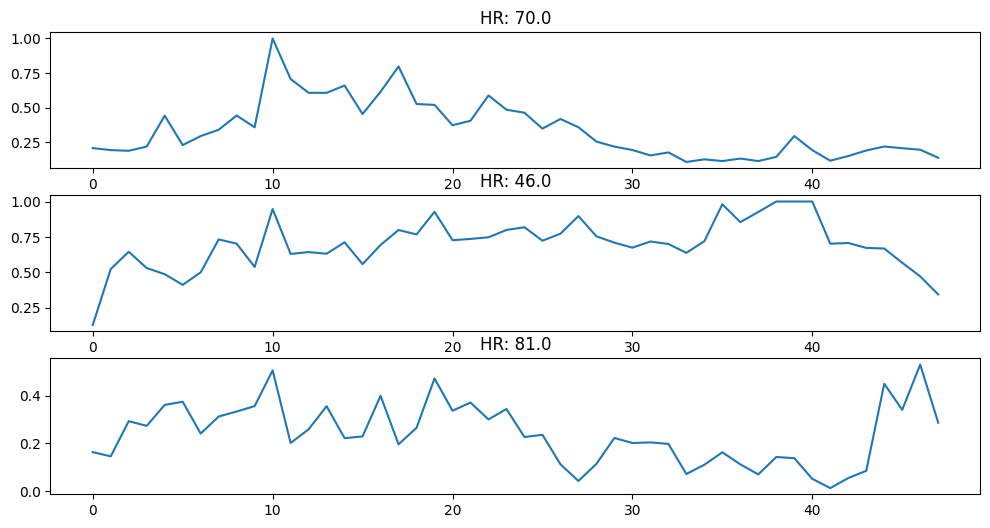

In [989]:
# hr series of the 3 largest residuals
fig, axs = plt.subplots(3, 1, figsize=(12, 6))
for i in largest_res:
    axs[largest_res.tolist().index(i)].plot(X_test[i].numpy())
    axs[largest_res.tolist().index(i)].set_title(f'HR: {all_actuals_test[i].item()}')
plt.show()

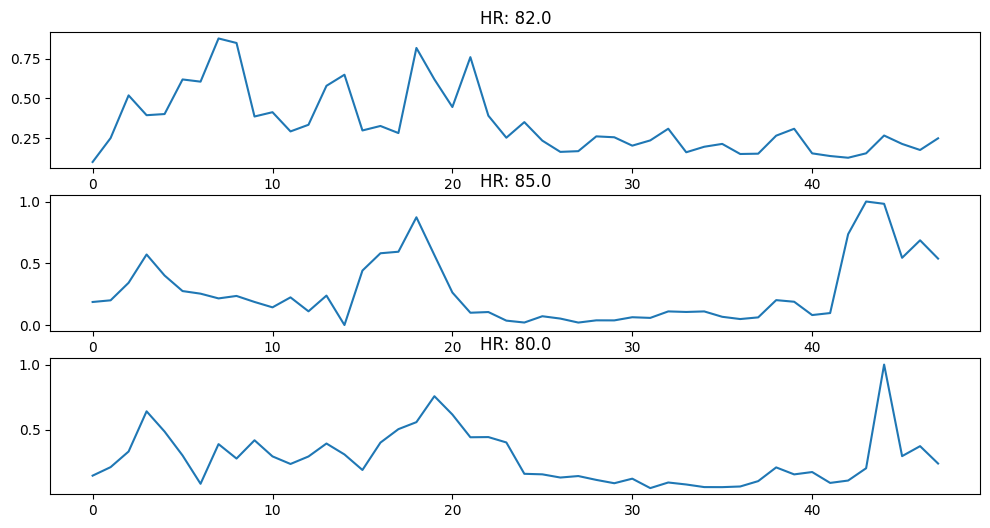

In [990]:
# hr series of the 3 smallest residuals
fig, axs = plt.subplots(3, 1, figsize=(12, 6))
for i in smallest_res:
    axs[smallest_res.tolist().index(i)].plot(X_test[i].numpy())
    axs[smallest_res.tolist().index(i)].set_title(f'HR: {all_actuals_test[i].item()}')
plt.show()